# 순차적 데이터(sequential data)
- 시간이나 순서에 따라 연속적으로 나타나는 데이터를 의미
- 시간이 지남에 따라 특정 순서를 따르며, 이전 값이 이후 값에 영향을 줄 수 있는 특성을 가짐
- 주요 특징
    - 시간 의존성
    > 이전 데이터 포인트가 이후 포인트에 영향을 미칠 수 있음
    - 순서 중요성
    > 데이터의 순서가 결과에 큰 영향을 준다. 순서가 바뀌면 의미가 달라질 수 있음
    -  연속적 흐름
    > 일반적으로 연속적으로 수집되거나 생성
    - 가변적 길이
    > 샘플마다 데이터의 길이가 다를 수 있음
- 주요 예시
    - 주식, 텍스트, 음성, 동영상, 기온 등


# 순환신경망(Recurrent Neural Networks)
- 순차적인 데이터의 특성을 반영하여, 이전 단계의 정보를 다음 단계로 전달할 수 있는 신경망
- 시계열 데이터나 자연어 처리와 같은 연속된 데이터의 패턴을 학습하고 예측하는 데 적합
- RNN은 일반적인 신경망과 달리, 데이터의 시간적 의존성을 반영할 수 있는 구조를 가지고 있음

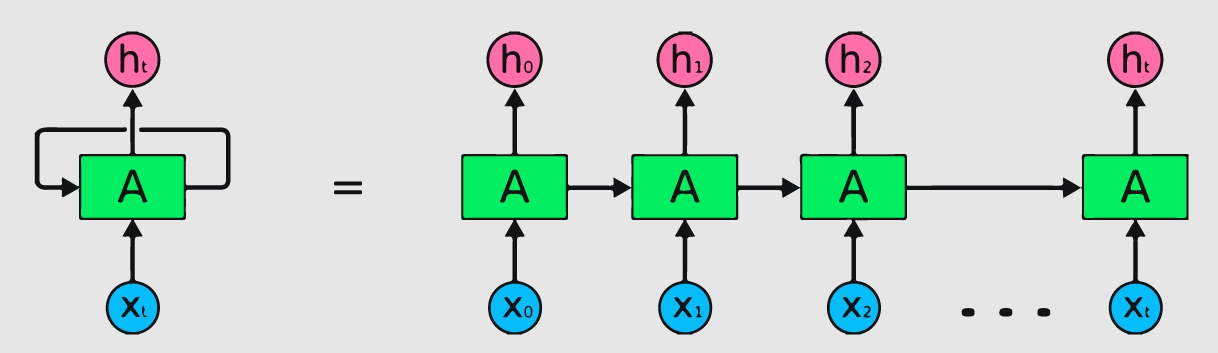

## RNN의 노드
- cell 이라고 한다.
- RNN의 각 노드의 출력을 hidden state(은닉상태) 라고 한다.
    - 은닉 상태는 각 시간 단계에서 데이터를 처리하면서 이전 단계의 정보를 기억하고, 다음 단계로 전달한다.
    - 이전 시간 단계에서 나온 은닉 상태가 다음 시간 단계로 전달되기 때문에, RNN이 이전의 문맥을 기억하고 활용할 수 있게 된다.

$$
h_t = \tanh(x_t W_{ih}^T + b_{ih} + h_{t-1}W_{hh}^T + b_{hh})
$$


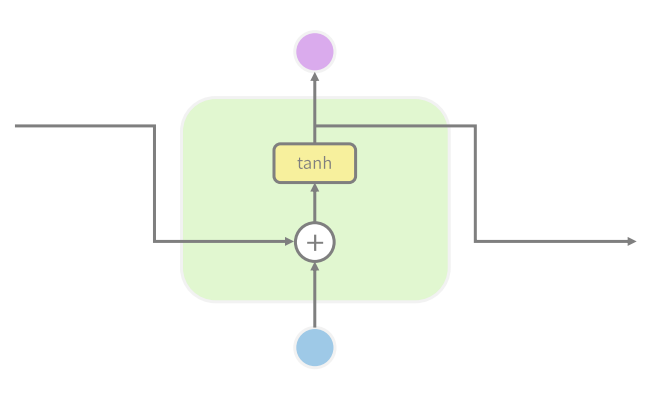

## RNN의 다양한 입출력 길이

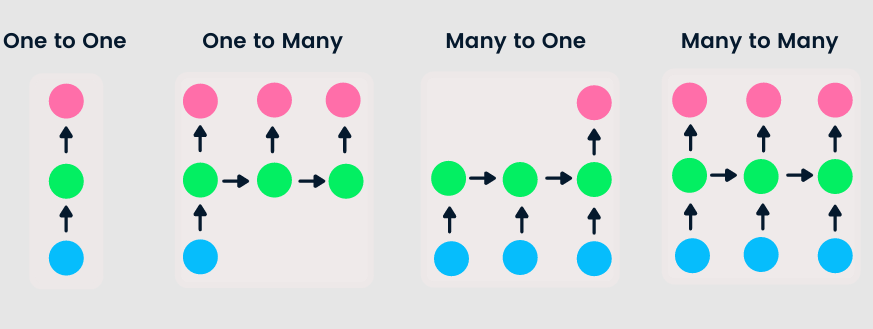

## Vanilla RNN 문제점
- 기울기 소실(Vanishing Gradient)
    - 긴 시퀀스를 학습할 때, 기울기 소실 문제가 발생하여 초기 단계의 정보가 뒷부분으로 전달되지 않는 문제가 있음
    - 장기 의존 관계를 잘 학습할 수 없음
- 기울기 폭발(Exploding Gradient)
    - 학습 도중 기울기가 너무 커져서 네트워크의 가중치가 지나치게 커지는 문제가 발생할 수 있음


In [2]:
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import random
import os

SEED = 42
def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

- pandas_datareader
    - api를 이용하지 않고 쉽게 주식 데이터를 가져올수 있는 라이브러리
    - https://pandas-datareader.readthedocs.io/en/latest/remote_data.html


In [4]:
import pandas_datareader.data as web

df = web.DataReader('005930', 'naver', start='2023-01-01', end='2023-12-31')
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2023-01-02,55500,56100,55200,55500,10031448
2023-01-03,55400,56000,54500,55400,13547030
2023-01-04,55700,58000,55600,57800,20188071
2023-01-05,58200,58800,57600,58200,15682826
2023-01-06,58300,59400,57900,59000,17334989


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245 entries, 2023-01-02 to 2023-12-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Open    245 non-null    object
 1   High    245 non-null    object
 2   Low     245 non-null    object
 3   Close   245 non-null    object
 4   Volume  245 non-null    object
dtypes: object(5)
memory usage: 11.5+ KB


In [4]:
df = df.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245 entries, 2023-01-02 to 2023-12-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Open    245 non-null    int64
 1   High    245 non-null    int64
 2   Low     245 non-null    int64
 3   Close   245 non-null    int64
 4   Volume  245 non-null    int64
dtypes: int64(5)
memory usage: 11.5 KB


In [5]:
df.head(50)

,Open,High,Low,Close,Volume
Date,,,,,
2023-01-02,55500,56100,55200,55500,10031448
2023-01-03,55400,56000,54500,55400,13547030
2023-01-04,55700,58000,55600,57800,20188071
2023-01-05,58200,58800,57600,58200,15682826
2023-01-06,58300,59400,57900,59000,17334989
2023-01-09,59700,60700,59600,60700,18640107
2023-01-10,60200,61100,59900,60400,14859797
2023-01-11,61000,61200,60300,60500,12310751
2023-01-12,61100,61200,59900,60500,16102561


In [6]:
data = df.to_numpy()
data

array([[   55500,    56100,    55200,    55500, 10031448],
       [   55400,    56000,    54500,    55400, 13547030],
       [   55700,    58000,    55600,    57800, 20188071],
       ...,
       [   76100,    76700,    75700,    76600, 13164909],
       [   76700,    78000,    76500,    78000, 20651042],
       [   77700,    78500,    77500,    78500, 17797536]])

In [7]:
mins = data.min(axis=0)
sizes = data.max(axis=0) - mins

(data - mins) / sizes

array([[0.0044843 , 0.00444444, 0.03043478, 0.004329  , 0.17389595],
       [0.        , 0.        , 0.        , 0.        , 0.31921842],
       [0.01345291, 0.08888889, 0.04782609, 0.1038961 , 0.59373696],
       ...,
       [0.92825112, 0.92      , 0.92173913, 0.91774892, 0.3034228 ],
       [0.95515695, 0.97777778, 0.95652174, 0.97835498, 0.61287465],
       [1.        , 1.        , 1.        , 1.        , 0.4949202 ]])

- 입력 길이(seq) 10일치, 정답데이터 길이 5일치의 종가

In [8]:
def transform_data(data, mins, sizes, seq_len=10, pred_len=5):
    data = (data - mins) / sizes
    x_list = []
    y_list = []

    for i in range(seq_len, len(data) + 1 - pred_len):
        x = data[i - seq_len:i]
        y = data[i:i + pred_len, 3]
        x_list.append(x)
        y_list.append(y)

    x_arr = np.array(x_list)
    y_arr = np.array(y_list)

    return x_arr, y_arr

In [9]:
x_arr, y_arr = transform_data(data, mins, sizes)
x_arr.shape, y_arr.shape

((231, 10, 5), (231, 5))

In [10]:
x_arr.shape # batch, sequence, feature

(231, 10, 5)

# 데이터셋 클래스

In [11]:
class FinanceDataset(torch.utils.data.Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        item = {}
        item["x"] = torch.Tensor(self.x[idx])
        if self.y is not None:
            item["y"] = torch.Tensor(self.y[idx])
        return item

In [12]:
dataset = FinanceDataset(x_arr, y_arr)
len(dataset), dataset[0]

(231,
 {'x': tensor([[0.0045, 0.0044, 0.0304, 0.0043, 0.1739],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.3192],
          [0.0135, 0.0889, 0.0478, 0.1039, 0.5937],
          [0.1256, 0.1244, 0.1348, 0.1212, 0.4075],
          [0.1300, 0.1511, 0.1478, 0.1558, 0.4758],
          [0.1928, 0.2089, 0.2217, 0.2294, 0.5297],
          [0.2152, 0.2267, 0.2348, 0.2165, 0.3735],
          [0.2511, 0.2311, 0.2522, 0.2208, 0.2681],
          [0.2556, 0.2311, 0.2348, 0.2208, 0.4249],
          [0.2287, 0.2311, 0.2565, 0.2338, 0.2764]]),
  'y': tensor([0.2468, 0.2424, 0.2165, 0.2641, 0.2771])})

In [47]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
batch = next(iter(dataloader))
batch

{'x': tensor([[[0.0045, 0.0044, 0.0304, 0.0043, 0.1739],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.3192],
          [0.0135, 0.0889, 0.0478, 0.1039, 0.5937],
          [0.1256, 0.1244, 0.1348, 0.1212, 0.4075],
          [0.1300, 0.1511, 0.1478, 0.1558, 0.4758],
          [0.1928, 0.2089, 0.2217, 0.2294, 0.5297],
          [0.2152, 0.2267, 0.2348, 0.2165, 0.3735],
          [0.2511, 0.2311, 0.2522, 0.2208, 0.2681],
          [0.2556, 0.2311, 0.2348, 0.2208, 0.4249],
          [0.2287, 0.2311, 0.2565, 0.2338, 0.2764]]]),
 'y': tensor([[0.2468, 0.2424, 0.2165, 0.2641, 0.2771]])}

In [48]:
batch['x'].shape # batch, seq, feature

torch.Size([1, 10, 5])

# RNN Layer
- input_size: 입력 데이터의 피처 수
- hidden_size: hidden state의 출력 피처 수
- num_layers: RNN layer 수(기본값 1)
- batch_first: 입력데이터의 batch 차원 첫번째 여부(기본값 False)
    - `True`: (batch, seq, feature)
    - `False`: (seq, batch, feature)
- bidirectional: 양방향 여부(기본값 False)

In [49]:
reset_seeds(SEED)
rnn = torch.nn.RNN(x_arr.shape[2], 16)
output, hn = rnn(batch["x"].permute(1, 0, 2)) # batch, seq, feature -> seq, batch, feature
print(output.shape) # seq, batch, feature
print(hn.shape) # nlayer, batch, feature

torch.Size([10, 1, 16])
torch.Size([1, 1, 16])


In [50]:
reset_seeds(SEED)
rnn = torch.nn.RNN(x_arr.shape[2], 16, batch_first=True)
output, hn = rnn(batch["x"])
print(output.shape) # batch, seq, feature
print(hn.shape) # nlayer, batch, feature

torch.Size([1, 10, 16])
torch.Size([1, 1, 16])


In [51]:
output[:, -1]

tensor([[ 0.1060,  0.3206, -0.1388,  0.0777,  0.1697, -0.0974, -0.3326,  0.1958,
         -0.0740, -0.2348,  0.0139, -0.2080, -0.0878,  0.0195,  0.0804, -0.0018]],
       grad_fn=<SelectBackward0>)

In [52]:
hn

tensor([[[ 0.1060,  0.3206, -0.1388,  0.0777,  0.1697, -0.0974, -0.3326,
           0.1958, -0.0740, -0.2348,  0.0139, -0.2080, -0.0878,  0.0195,
           0.0804, -0.0018]]], grad_fn=<StackBackward0>)

In [54]:
hn[-1].shape # batch, feature

torch.Size([1, 16])

- RNN layer 수
    - 순환신경망을 여러 개 쌓을 수 있음

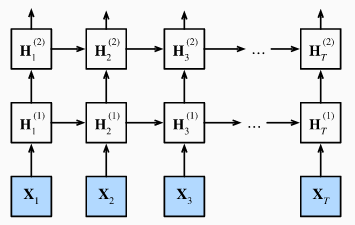

In [80]:
reset_seeds(SEED)
rnn = torch.nn.RNN(x_arr.shape[2], 16, batch_first=True, num_layers=2)
output, hn = rnn(batch["x"])
print(output.shape) # batch, seq, feature
print(hn.shape) # nlayer, batch, feature

torch.Size([1, 10, 16])
torch.Size([2, 1, 16])


In [81]:
print(output[:, -1]) # batch, feature
print(hn[-1]) # batch, feature

tensor([[-0.0735,  0.0531, -0.0493,  0.2707,  0.4491,  0.0411,  0.3417, -0.1877,
         -0.2657, -0.0089, -0.4345,  0.0164,  0.1962,  0.0152, -0.5012,  0.1802]],
       grad_fn=<SelectBackward0>)
tensor([[-0.0735,  0.0531, -0.0493,  0.2707,  0.4491,  0.0411,  0.3417, -0.1877,
         -0.2657, -0.0089, -0.4345,  0.0164,  0.1962,  0.0152, -0.5012,  0.1802]],
       grad_fn=<SelectBackward0>)


- 양방향 여부

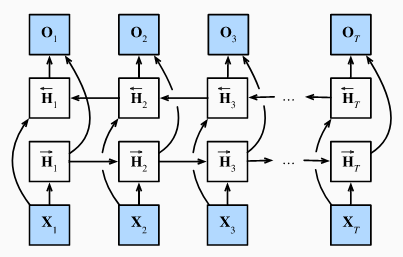

In [82]:
reset_seeds(SEED)
rnn = torch.nn.RNN(x_arr.shape[2], 16, bidirectional=True, batch_first=True)
output, hn = rnn(batch["x"])
print(output.shape) # batch, seq, feature
print(hn.shape) # nlayer, batch, feature

torch.Size([1, 10, 32])
torch.Size([2, 1, 16])


In [64]:
print(output[:, -1, :16])
print(output[:, 0, 16:])

tensor([[ 0.1060,  0.3206, -0.1388,  0.0777,  0.1697, -0.0974, -0.3326,  0.1958,
         -0.0740, -0.2348,  0.0139, -0.2080, -0.0878,  0.0195,  0.0804, -0.0018]],
       grad_fn=<SliceBackward0>)
tensor([[ 0.0249, -0.2321,  0.1182,  0.0373, -0.4371,  0.1355, -0.0380, -0.0402,
         -0.2926, -0.4796,  0.4312, -0.0706,  0.2065,  0.0690, -0.0905,  0.0258]],
       grad_fn=<SliceBackward0>)


In [74]:
hn

tensor([[[ 0.1060,  0.3206, -0.1388,  0.0777,  0.1697, -0.0974, -0.3326,
           0.1958, -0.0740, -0.2348,  0.0139, -0.2080, -0.0878,  0.0195,
           0.0804, -0.0018]],

        [[ 0.0249, -0.2321,  0.1182,  0.0373, -0.4371,  0.1355, -0.0380,
          -0.0402, -0.2926, -0.4796,  0.4312, -0.0706,  0.2065,  0.0690,
          -0.0905,  0.0258]]], grad_fn=<StackBackward0>)

In [69]:
# nlayer, batch, feature -> batch, nlayer, feature -> batch, nlayer * feature
hn.permute(1, 0, 2).flatten(1).shape

torch.Size([1, 32])

# 모델 클래스

In [75]:
class Net(torch.nn.Module):
    def __init__(self, n_features, hidden_size, pred_len):
        super().__init__()
        self.rnn_layer = torch.nn.RNN(n_features, hidden_size, batch_first=True)
        self.fc_layer = torch.nn.Linear(hidden_size, hidden_size // 2)
        self.relu = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(hidden_size // 2, pred_len)

    def forward(self, x):
        # output: batch, seq, feature
        # hn: nlayer, batch, feature
        output, hn = self.rnn_layer(x)
        x = hn[-1] # nlayer, batch, feature -> batch, feature
        x = self.fc_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

In [76]:
class Net(torch.nn.Module):
    def __init__(self, n_features, hidden_size, pred_len):
        super().__init__()
        self.rnn_layer = torch.nn.RNN(n_features, hidden_size, batch_first=True, bidirectional=True)
        self.fc_layer = torch.nn.Linear(hidden_size * 2, hidden_size)
        self.relu = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(hidden_size, pred_len)

    def forward(self, x):
        # output: batch, seq, feature
        # hn: nlayer, batch, feature
        output, hn = self.rnn_layer(x)

        # nlayer, batch, feature -> batch, nlayer, feature -> batch, nlayer * feature
        x = hn.permute(1, 0, 2).flatten(1)

        x = self.fc_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

In [77]:
model = Net(x_arr.shape[2], 16, y_arr.shape[1])
model(batch["x"])

tensor([[-0.2809,  0.2250,  0.0193, -0.0510,  0.1934]],
       grad_fn=<AddmmBackward0>)

# 학습 loop 함수

In [83]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train() # 학습 모드로 전환
    epoch_loss = 0

    for batch in dataloader: # 배치단위로 데이터 반환
        pred = model(batch["x"].to(device)) # 예측
        loss = loss_fn(pred, batch["y"].to(device)) # 손실 계산

        optimizer.zero_grad() # 이전 경사 누적을 방지하기 위해 0으로 초기화
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트

        epoch_loss += loss.item() # 에폭 loss 를 계산하기 위해 배치 loss 합

    epoch_loss /= len(dataloader) # 에폭 loss 구함

    return epoch_loss

# 테스트 loop 함수

In [84]:
@torch.no_grad() # with 문과 같은 역할
def test_loop(dataloader, model, loss_fn, device):
    model.eval() # 평가 모드
    epoch_loss = 0
    pred_list = []

    for batch in dataloader:
        pred = model(batch["x"].to(device))
        if batch.get("y") is not None: # y 키에 텐서가 있을 경우만 loss 계산
            loss = loss_fn(pred, batch["y"].to(device))
            epoch_loss += loss.item()

        pred = pred.to("cpu").numpy()
        pred_list.append(pred)

    epoch_loss /= len(dataloader)
    pred = np.concatenate(pred_list)
    return epoch_loss, pred

# 학습

In [85]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

n_splits = 5 # K-fold k 값
n_features = x_arr.shape[2] # 입력 데이터의 피처 수
hidden_size = 16 # RNN 레이어의 출력 피처 개수
pred_len = y_arr.shape[1] # 예측 길이(output layer 노드 수)
batch_size = 32
epochs = 1000
cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_function = torch.nn.MSELoss()

In [86]:
is_holdout = False
reset_seeds(SEED)
score_list = []

for i, (tri, vai) in enumerate(cv.split(x_arr)):
    # 학습데이터
    train_dataset = FinanceDataset(x_arr[tri], y_arr[tri])
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # 검증데이터
    valid_dataset = FinanceDataset(x_arr[vai], y_arr[vai])
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    model = Net(n_features, hidden_size, pred_len).to(device)
    optimizer = torch.optim.Adam(model.parameters())

    best_score = np.inf
    patience = 0
    for _ in tqdm(range(epochs)):
        train_loss = train_loop(train_dataloader, model, loss_function, optimizer, device)
        valid_loss, pred = test_loop(valid_dataloader, model, loss_function, device)

        pred = pred * sizes[3] + mins[3]
        true = y_arr[vai] * sizes[3] + mins[3]
        score = mean_absolute_error(true, pred)
        patience += 1

        if score < best_score:
            patience = 0
            best_score = score
            torch.save(model.state_dict(), f"model_{i}.pt")

        if patience == 5:
            break

    score_list.append(best_score)
    print(f"Fold {i} MAE: {best_score}")

    if is_holdout:
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

Fold 0 MAE: 1113.063796542553


  0%|          | 0/1000 [00:00<?, ?it/s]

Fold 1 MAE: 1349.014351222826


  0%|          | 0/1000 [00:00<?, ?it/s]

Fold 2 MAE: 1228.9826936141303


  0%|          | 0/1000 [00:00<?, ?it/s]

Fold 3 MAE: 969.8338145380434


  0%|          | 0/1000 [00:00<?, ?it/s]

Fold 4 MAE: 1121.6636379076087


In [87]:
np.mean(score_list)

1156.5116587650323

# 예측

- 2024-01-01 ~ 2024-03-31 주식 가격 예측

In [88]:
test_df = web.DataReader('005930', 'naver', start='2024-01-01', end='2024-03-31')
test_df = test_df.astype(int)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2024-01-02 to 2024-03-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Open    61 non-null     int64
 1   High    61 non-null     int64
 2   Low     61 non-null     int64
 3   Close   61 non-null     int64
 4   Volume  61 non-null     int64
dtypes: int64(5)
memory usage: 2.9 KB


In [89]:
test_df = pd.concat([df.iloc[-10:], test_df])
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71 entries, 2023-12-14 to 2024-03-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Open    71 non-null     int64
 1   High    71 non-null     int64
 2   Low     71 non-null     int64
 3   Close   71 non-null     int64
 4   Volume  71 non-null     int64
dtypes: int64(5)
memory usage: 3.3 KB


In [90]:
test_data = test_df.to_numpy()
x_test, y_test = transform_data(test_data, mins, sizes)
x_test.shape, y_test.shape

((57, 10, 5), (57, 5))

In [91]:
test_dataset = FinanceDataset(x_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [92]:
pred_list = []

for i in range(n_splits):
    nodel = Net(n_features, hidden_size, pred_len)
    state_dict = torch.load(f"model_{i}.pt", weights_only=True)
    nodel.load_state_dict(state_dict)

    _, pred = test_loop(test_dataloader, model, None, device)
    pred_list.append(pred)

pred = np.mean(pred_list, axis=0)
pred.shape

(57, 5)

In [93]:
pred = pred * sizes[3] + mins[3]
true = y_test * sizes[3] + mins[3]
mean_absolute_error(true, pred)

1653.5526589912283